In [123]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv


# 1 Blob Detection

Laplacian of Gaussian\
$∇²_{norm}g = \sigma^2(\frac{∂²g}{∂x²} + \frac{∂²g}{∂y²})$



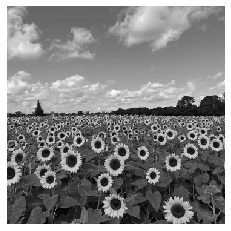

(360, 360)


In [109]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("images/the_berry_farms_sunflower_field.jpeg",cv2.IMREAD_REDUCED_COLOR_4)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
assert img is not None

fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest',cmap="gray")
ax.set_axis_off()
ax.plot()
plt.show()

print(img.shape)
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 3.0
img = img/255.0
#imshow(img,cmap="gray")

In [110]:
def LoG(sigma):
    #window size
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) * (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

def LoG_convolve(img):
    log_images = []
    for i in range(1,10):
        y = np.power(k,i)
        sigma_1 = sigma*y
        filter_log = LoG(sigma_1)
        image = cv2.filter2D(img,-1,filter_log)
        image = np.pad(image,((1,1),(1,1)),'constant')
        image = np.square(image)
        log_images.append(image)
    log_image_np = np.array([i for i in log_images])
    return log_image_np
log_image_np = LoG_convolve(img)
print(log_image_np.shape)



(9, 362, 362)


In [111]:
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)

    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim

    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))

    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))

def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])

In [112]:
def detect_blob(log_image_np):
    co_ordinates = []
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2]
            result = np.amax(slice_img)
            #result_1 = np.amin(slice_img)
            if result >= 0.03:
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma))
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

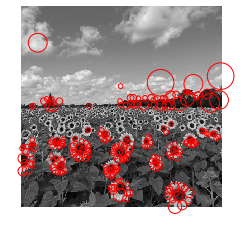

In [113]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1, fill=False)
    
    ax.add_patch(c)
ax.plot()
ax.set_axis_off()
plt.show()

# 2 

## Noisy Point Set Generation

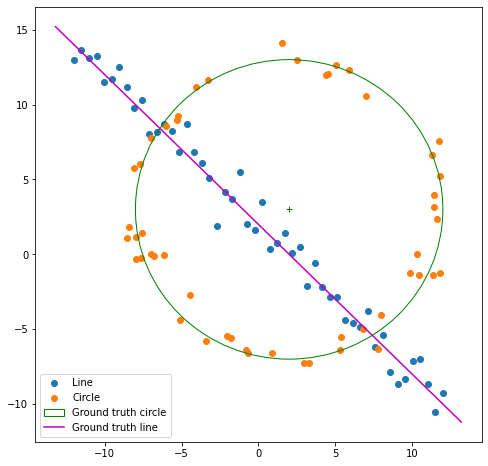

In [124]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# Constants
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

# Generate random points for the circle
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Generate random points for the line
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine all points
X = np.vstack((X_circ, X_line))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the line points
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')

# Scatter plot for the circle points
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


## Line Estimation using RNASAC

In [125]:
import math
N = X.shape[0]
dataset = X

In [126]:
def line_equation_from_points(x1, y1, x2, y2):
    """ Return the line equation in the form ax + by = d"""
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    return a, b, d

def line_tls(x, indices):
    """ Return the total least squares error for the line model"""
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*dataset[indices,0] + b*dataset[indices,1] - d))

def g(x):
    """ Constraint """
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X, x, t):
    """ Computing the inliners """
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*dataset[:,0] + b*dataset[:,1] - d)
    return error < t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.217294645410139e-10
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.674829762527681
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1157412653211744e-09
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.272833661749765e-09
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.176387391469904e-10
            Iterations: 9
            Function

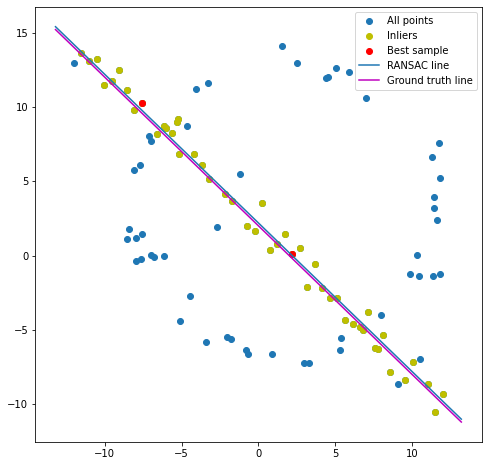

In [127]:
t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []                                                                                                           # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = []                                                                                                            # Best model normal (a, b) and distance from origin d
best_error = np.inf 
best_sample_line = []                                                                                                               # Three-point sample leading to the best model computation
res_only_with_sample = []                                                                                                           # Result (a, b, d) only using the best sample
best_inliers_line = []                                                                                                          # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(dataset, res.x, t) # Computing the inliers
    if inliers_line.sum() > d:
        x0 = res.x
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        if res.fun < best_error:
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = dataset[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1

print('Best line model', best_model_line)

print(dataset.shape)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

## Circle Estimation using RANSAC for the Remnant

(54, 2)


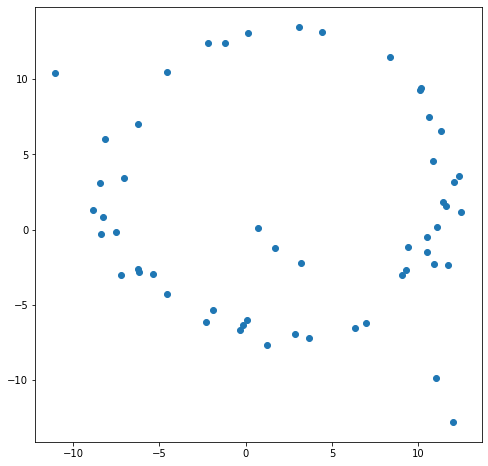

In [120]:
from scipy import optimize
import random

# Extract the outliers (data points that are not inliers)
outliers_indices = np.where(np.logical_not(best_inliers_line))[0]
outliers_data = dataset[outliers_indices, :]
#print(outliers_data)
print(outliers_data.shape)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(outliers_data[:,0],outliers_data[:,1], label='All points')

N = outliers_data.shape[0]

def circle_equation(points):
    """ Return the center and radius of the circle from three points """
    p1,p2,p3 = points[0], points[1], points[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """ Returns the list of inliers to a model of a circle from a set of points. The threshold value is taken as 1/3 rd of the radius """
    inliers = []
    thresh = r//3

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    """ Returns a list of 3 random samples from a given list """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def calc_R(x_, y_, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))

    xc_2, yc_2 = center_2

    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    # residu_2   = sum((Ri_2 - R_2)**2)
    return (xc_2, yc_2), R_2

In [128]:
# RANSAC_Circle
def RANSAC_Circle(data_list, itr):
    """ Return the center, radius and the best sample and its inliers used to fit the circle to a set of points using RANSAC_Circle """
    best_sample = []
    best_center_sample = (0,0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = len(data_list)*0.9
    
    for i in range(itr):
        samples = random_sample(data_list)  # Generating a random sample of 3 points
        center, radius = circle_equation(samples) # Calculting the center and the radius of the circle created by the 3 points
        inliers = get_inliers(data_list, center, radius) # Get the list of inliers
        num_inliers = len(inliers)

        # If a better approximation has been reached
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers

    print("Center of Sample=", best_center_sample)
    print("Radius of Sample=", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers

Center of Sample= (0, 0)
Radius of Sample= 0
(54, 2)
Ratio of inliers = 0.0 %


TypeError: list indices must be integers or slices, not tuple

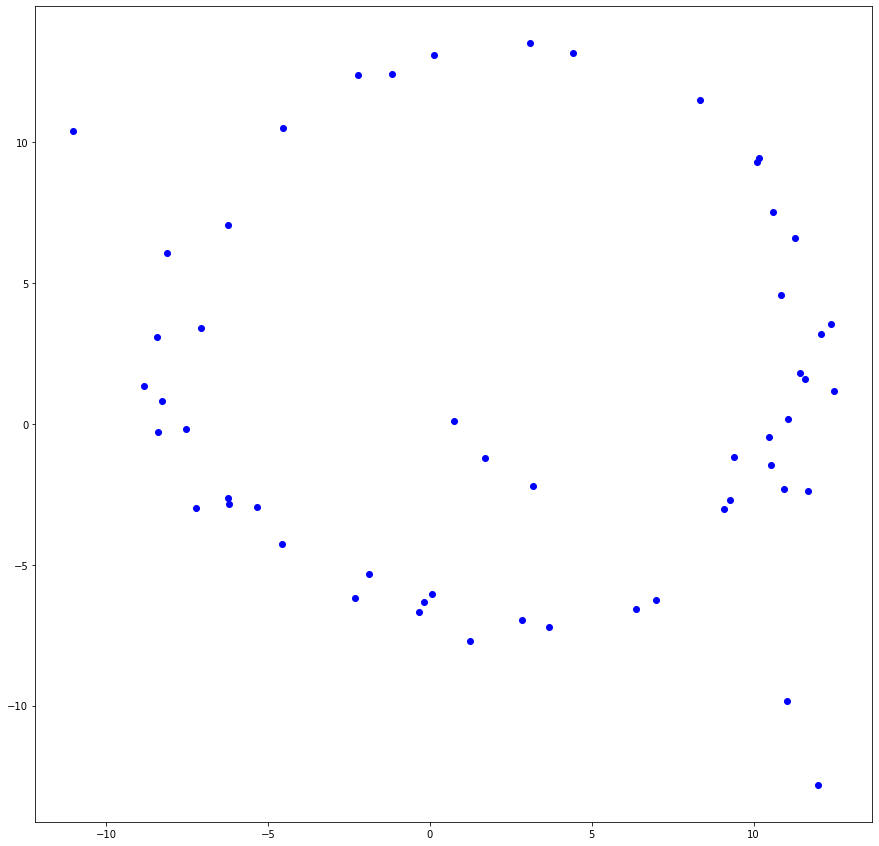

In [129]:
# Calculting the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC_Circle(outliers_data, 50000)
print(outliers_data.shape)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (15,15))
plt.scatter(outliers_data[:,0], outliers_data[:,1], color = 'blue', label = "Data points")
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

Ratio of inliers = 112.00000000000001 %
Center of RANSAC = (2.2776005507086525, 3.843677251525788)
Radius of RANSAC = 9.448146656018679


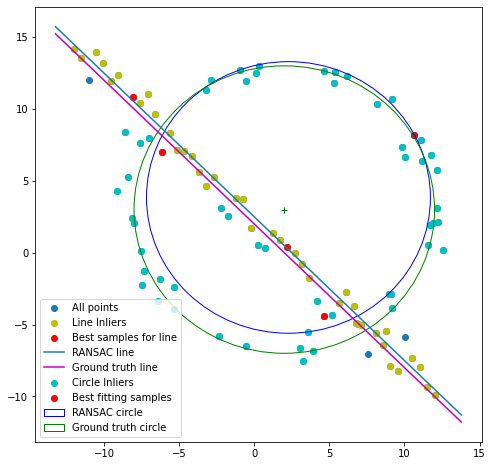

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')


# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'c', label = "Circle Inliers")

ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC circle", color = 'b')
ax.add_patch(circle)

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

ax.legend()
plt.legend()

In [ ]:
# Calculting the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC_Circle(dataset, 50000)
print(dataset.shape)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (15,15))
plt.scatter(outliers_data[:,0], outliers_data[:,1], color = 'blue', label = "Data points")
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

NameError: name 'RANSAC_Circle' is not defined

# 3

Text(0.5, 1.0, 'Image Warpped')

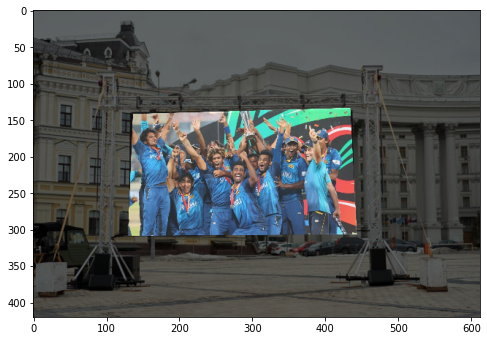

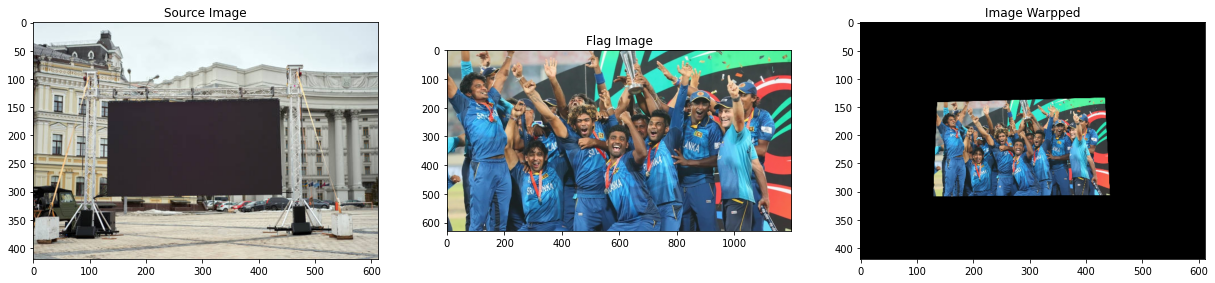

In [59]:
N = 4 # Number of points
n = 0

# Parameters of the two images
p = np.empty((N,2))
p_flag = np.empty((N,2))

# Mouse callback function
def draw(event,x,y,flags,param):
    global n
    p = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        p[n] = (x,y)
        n += 1

# Importing the images and creating copies
image_background = cv.imread('images/big screen.jpg', cv.IMREAD_COLOR)
image_superimposed = cv.imread('images/i(1).jpg', cv.IMREAD_COLOR)
image_background_copy = image_background.copy()
image_superimposed_copy = image_superimposed.copy()

# Getting the mouse points of the base image
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [p, image_background_copy]
cv.setMouseCallback('Image',draw, param)
while(1):
    cv.imshow('Image', image_background_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break

# Getting the mouse points of the flag
n = 0
cv.namedWindow('Image Flag', cv.WINDOW_AUTOSIZE)
param = [p_flag, image_superimposed_copy]
cv.setMouseCallback('Image Flag',draw, param)
while(1):
    cv.imshow('Image Flag', image_superimposed_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break
cv.destroyAllWindows()


h, status = cv.findHomography(p, p_flag) # Calculating homography between image and flag

# Warping image of flag
warped_img = cv.warpPerspective(image_superimposed, np.linalg.inv(h), (image_background.shape[1],image_background.shape[0])) 

blended = cv.addWeighted(image_background, 0.4, warped_img, 0.9, 0.0)
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

# Plotting the results
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(cv.cvtColor(image_background,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(image_superimposed,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(warped_img,cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warpped")

# 4

In [61]:
# Import images
img1 = cv.imread('images/graffiti/img1.ppm')  
img2 = cv.imread('images/graffiti/img2.ppm')  
img3 = cv.imread('images/graffiti/img3.ppm')  
img4 = cv.imread('images/graffiti/img4.ppm')  
img5 = cv.imread('images/graffiti/img5.ppm')
assert img1 is not None
assert img2 is not None
assert img3 is not None
assert img4 is not None
assert img5 is not None

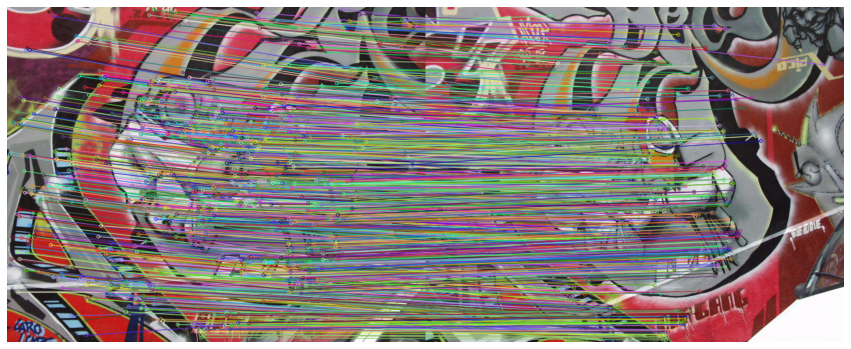

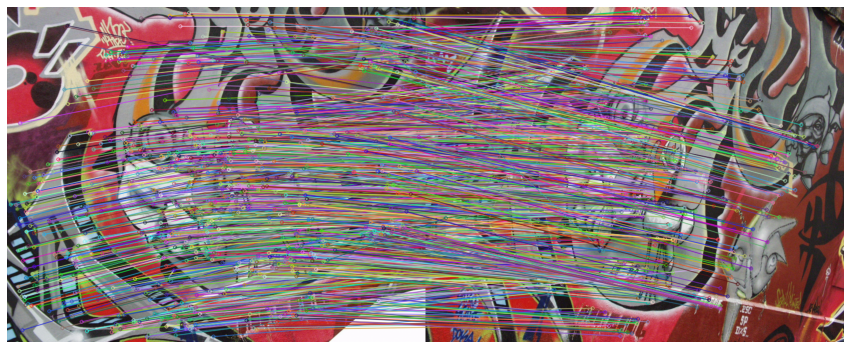

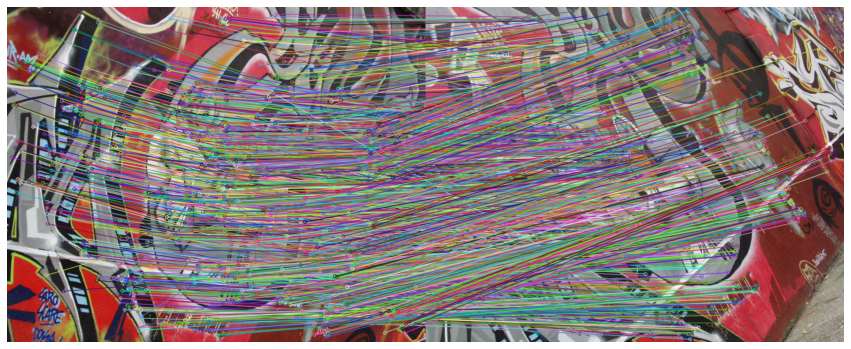

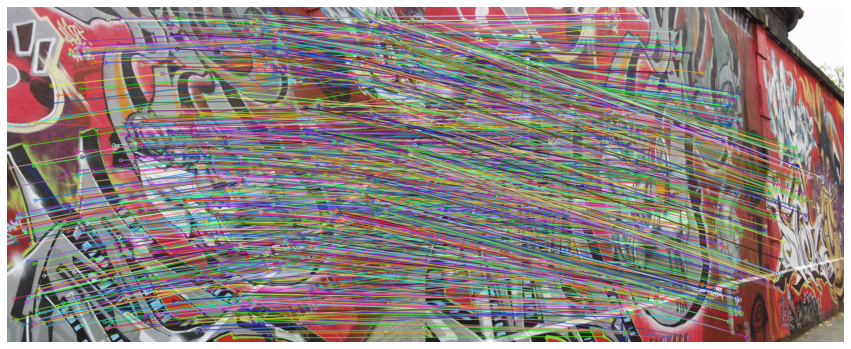

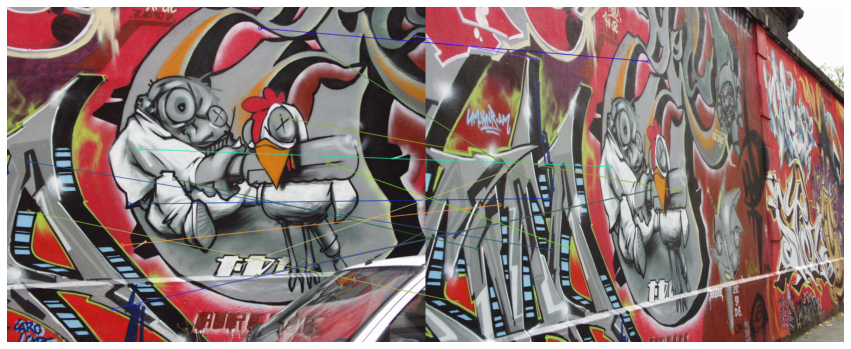

In [80]:
def sift_match(im1, im2):
    GOOD_MATCH_PERCENT = 0.65
    # Detect sift features
    sift = cv.SIFT_create()
    keypoint_1, descriptors_1 = sift.detectAndCompute(im1,None)
    keypoint_2, descriptors_2 = sift.detectAndCompute(im2,None)
    # Match features.
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k = 2) 
    # Filter good matches using ratio test in Lowe's paper
    good_matches = []
    for a,b in matches:
        if a.distance < GOOD_MATCH_PERCENT*b.distance:
            good_matches.append(a)
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)
    for i, match in enumerate(good_matches):
        points1[i, :] = keypoint_1[match.queryIdx].pt
        points2[i, :] = keypoint_2[match.trainIdx].pt

    # Plot the matching
    fig, ax = plt.subplots(figsize = (15,15))
    ax.axis('off')
    matched_img = cv.drawMatches(im1, keypoint_1, im2, keypoint_2, good_matches, im2, flags = 2)
    plt.imshow(cv.cvtColor(matched_img,cv.COLOR_BGR2RGB))
    plt.show()

    result = np.concatenate((points1,points2), axis = 1)
    return result

match1_2 = sift_match(img1,img2)
match2_3 = sift_match(img2,img3)
match3_4 = sift_match(img3,img4)
match4_5 = sift_match(img4,img5)
match1_5 = sift_match(img1,img5)

In [81]:
def calculateHomography(correspondences):
    temp_list = []
    for points in correspondences:
        p1 = np.matrix([points.item(0), points.item(1), 1]) # (x1,y1)
        p2 = np.matrix([points.item(2), points.item(3), 1]) # (x2,y2)

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        temp_list.append(a1)
        temp_list.append(a2)

    assemble_matrix = np.matrix(temp_list)

    #svd composition
    u, s, v = np.linalg.svd(assemble_matrix)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize 
    h = (1/h.item(8)) * h
    return h

# Generate Correspondence Matrices
correspondenceMatrix1_2 = np.matrix(match1_2)
correspondenceMatrix2_3 = np.matrix(match2_3)
correspondenceMatrix3_4 = np.matrix(match3_4)
correspondenceMatrix4_5 = np.matrix(match4_5)
correspondenceMatrix1_5 = np.matrix(match1_5)

In [82]:
import random
def loss(matched_points, h):
    point1 = np.transpose(np.matrix([matched_points[0].item(0), matched_points[0].item(1), 1]))
    point2 = np.transpose(np.matrix([matched_points[0].item(2), matched_points[0].item(3), 1]))
    
    # Estimate the point after applying the homography
    transformed_point2 = np.dot(h, point1)
    transformed_point2 = (1/transformed_point2.item(2))*transformed_point2

    # Calculate the error between the actual and estimated point
    error = point2 - transformed_point2
    
    return np.linalg.norm(error)

def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def ransac(matched_points):
    maxInliers = 0
    best_H = None
    for i in range(10):
        random_points = random_sample(matched_points)

        # Generate the homography 
        homography = calculateHomography(random_points)
        num_inliers = 0

        # Find the inliers
        for i in range(len(matched_points)):
            d = loss(matched_points[i], homography)
            if d < 3:
                num_inliers += 1

        if num_inliers > maxInliers:
            maxInliers = num_inliers
            best_H = homography
    
    return best_H

# Run ransac algorithm
H1_2 = ransac(correspondenceMatrix1_2)
H2_3 = ransac(correspondenceMatrix2_3)
H3_4 = ransac(correspondenceMatrix3_4)
H4_5 = ransac(correspondenceMatrix4_5)
H1_5 = ransac(correspondenceMatrix1_5)


In [86]:
def homography_reshape(homography):
    homography_ = np.array(homography)
    homography_ = homography_.reshape(3,3)
    homography_ = homography_/(homography_[-1][-1])
    return homography_

# Reshaping the homography to the matric format
H1_2 = homography_reshape(H1_2)
H2_3 = homography_reshape(H2_3)
H3_4 = homography_reshape(H3_4)
H4_5 = homography_reshape(H4_5)
H1_5 = homography_reshape(H1_5)

H1_5 = H4_5@H3_4@H2_3@H1_2
H1_5 = homography_reshape(H1_5)
print(H1_5)


[[ 6.70443673e+00 -7.22470754e+00 -1.39447473e+00]
 [ 5.29689825e+00 -5.17070305e+00 -2.37703088e+02]
 [ 1.02250666e-02 -1.32862858e-02  1.00000000e+00]]


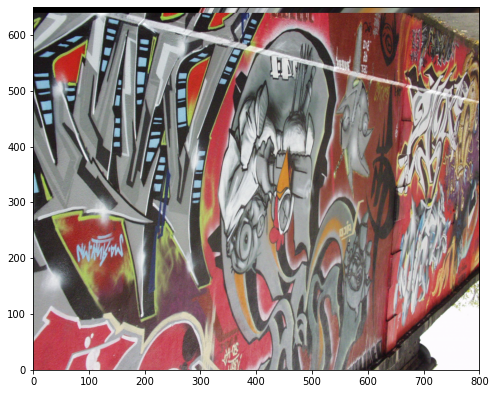

In [85]:
width = img1.shape[1] + img2.shape[1]
height = img1.shape[0] + img2.shape[0]
result = cv.warpPerspective(img1, H1_5, (width, height))
result[0:img5.shape[0], 0:img5.shape[1]] = img5
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.set_xlim([0, 800])
ax.set_ylim([0, 650])
ax.imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))